In [1]:
import os 
import glob
import tiktoken
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader,TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from openai import OpenAI



In [2]:
load_dotenv(override=True)
db_name = "vector_db"

openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key:
  print("It's there fellas")
Model = "gpt-4.1-nano"
openai=OpenAI(api_key=openai_api_key) 

It's there fellas


In [3]:
# How many charcters are teher in knowledge base
knowledge_base_path= "**/*.md"
entire_knowledge_base=""
files = glob.glob(knowledge_base_path,recursive=True)
for file in files:
  with open(file,'r',encoding="utf-8") as f:
    entire_knowledge_base+=f.read()
    entire_knowledge_base+="\n\n"
print(f"Total characters in knowledge base: {len(entire_knowledge_base)}")
print(f"Total Words in knowledge base: {len(entire_knowledge_base.split())}")

Total characters in knowledge base: 304434
Total Words in knowledge base: 40532


In [4]:
encoding = tiktoken.encoding_for_model(Model)
tokens = encoding.encode(entire_knowledge_base)
token_count = len(tokens)
print(f"Totla tokens for {Model}:{token_count:,}")


Totla tokens for gpt-4.1-nano:63,555


### A quick detour to understand the from langchain_community.document_loaders import TextLoader and DirectoryLoader


DirectoryLoader takes folder struct and loader class to say how the data needs to be read TextLoader is the most common nd simple one for reading text and .md

In [5]:
from langchain_community.document_loaders import TextLoader,PyPDFLoader,DirectoryLoader

loader_mapping = {
  ".md":TextLoader,
  ".pdf":PyPDFLoader
}

loader = DirectoryLoader(
  "./company/",glob="**/*.*",loader_cls=TextLoader,show_progress=True,loader_kwargs={'encoding':'utf-8'}
)


In [6]:
loader.load()

100%|██████████| 4/4 [00:00<00:00, 1817.68it/s]


[Document(metadata={'source': 'company\\about.md'}, page_content="# About Insurellm\n\nInsurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. Its first product was Markellm, the marketplace connecting consumers with insurance providers.\n\nThe company experienced rapid growth in its first five years, expanding its product portfolio to include Carllm (auto insurance portal), Homellm (home insurance portal), and Rellm (enterprise reinsurance platform). By 2020, Insurellm had reached a peak of 200 employees with 12 offices across the US.\n\nHowever, the company underwent a strategic restructuring in 2022-2023 to focus on profitability and sustainable growth. This included consolidating office locations, implementing a remote-first strategy, and streamlining operations. As of 2025, Insurellm operates with a lean, highly efficient team of 32 employees who have built a portfolio of 32 active contracts span

In [7]:
pdf_loader = DirectoryLoader(
    "./company/", 
    glob="**/*.pdf", 
    loader_cls=PyPDFLoader
)


In [8]:
pdf_loader.load()

[]

### A return to reality

In [9]:
folders = glob.glob("./*/")
documents = []
folders


['.\\company\\',
 '.\\contracts\\',
 '.\\employees\\',
 '.\\products\\',
 '.\\vector_db\\']

In [10]:
from langchain_community.document_loaders import DirectoryLoader,TextLoader

for folder in folders:
  dir_name = folder.split("/")[-1].replace('//','').replace('\\','').replace('.','')
  print(folder)
  loader = DirectoryLoader(path=folder,glob="**/*.md",loader_cls=TextLoader,loader_kwargs={'encoding':"utf-8"},recursive=True)
  
  folder_docs = loader.load()

  for doc in folder_docs:
    doc.metadata["doc_type"] = dir_name
    documents.append(doc)
print(f"Successfully loaded {len(documents)} documents from {len(folders)} categories.")

.\company\
.\contracts\
.\employees\
.\products\
.\vector_db\
Successfully loaded 76 documents from 5 categories.


In [11]:
documents[0]

Document(metadata={'source': 'company\\about.md', 'doc_type': 'company'}, page_content="# About Insurellm\n\nInsurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. Its first product was Markellm, the marketplace connecting consumers with insurance providers.\n\nThe company experienced rapid growth in its first five years, expanding its product portfolio to include Carllm (auto insurance portal), Homellm (home insurance portal), and Rellm (enterprise reinsurance platform). By 2020, Insurellm had reached a peak of 200 employees with 12 offices across the US.\n\nHowever, the company underwent a strategic restructuring in 2022-2023 to focus on profitability and sustainable growth. This included consolidating office locations, implementing a remote-first strategy, and streamlining operations. As of 2025, Insurellm operates with a lean, highly efficient team of 32 employees who have built a portfolio of 32

Now a detour to chunks RecursiveTextSplitter there are many ways to seperate chunks to get the meaning out of the TEXT. (Notes written)

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)

chunks = text_splitter.split_documents(documents)

print(f"Divided into {len(chunks)} chunks")
print(f"First chunk:\n\n{chunks[0]}")

Divided into 413 chunks
First chunk:

page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. Its first product was Markellm, the marketplace connecting consumers with insurance providers.

The company experienced rapid growth in its first five years, expanding its product portfolio to include Carllm (auto insurance portal), Homellm (home insurance portal), and Rellm (enterprise reinsurance platform). By 2020, Insurellm had reached a peak of 200 employees with 12 offices across the US.' metadata={'source': 'company\\about.md', 'doc_type': 'company'}


In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
if os.path.exists(db_name):
  Chroma(persist_directory=db_name,embedding_function=embeddings).delete_collection()


In [14]:
vectorstore = Chroma.from_documents(documents=chunks,embedding=embeddings,persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 413 documents


In [15]:
#lets investigate the vectors 
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1,include=['embeddings'])['embeddings'][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 413 vectors with 1,536 dimensions in the vector store


In [16]:
embeddings = collection.get(include=['embeddings'])['embeddings'][0]
len(embeddings)

1536

In [17]:
import numpy as np
result = collection.get(include=['embeddings','documents','metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue','green','red','orange'] [['products','employees','contracts','company'].index(t)] for t in doc_types]


In [18]:
vectors

array([[-0.00115266, -0.00159927, -0.00674088, ...,  0.00136231,
        -0.02142429,  0.01582082],
       [-0.00370892, -0.00505522,  0.08225623, ..., -0.00357033,
        -0.02103922,  0.04316076],
       [ 0.01596763,  0.00530233,  0.04710787, ..., -0.0226646 ,
         0.00233114,  0.04204135],
       ...,
       [-0.00051914,  0.02416929,  0.06736413, ..., -0.00666783,
        -0.01468193,  0.01395799],
       [ 0.02335067,  0.01892464,  0.0495179 , ..., -0.00180562,
        -0.02213016, -0.00668599],
       [ 0.02666431, -0.01218024,  0.02208281, ..., -0.01048508,
        -0.02796022,  0.01576035]], shape=(413, 1536))

In [19]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

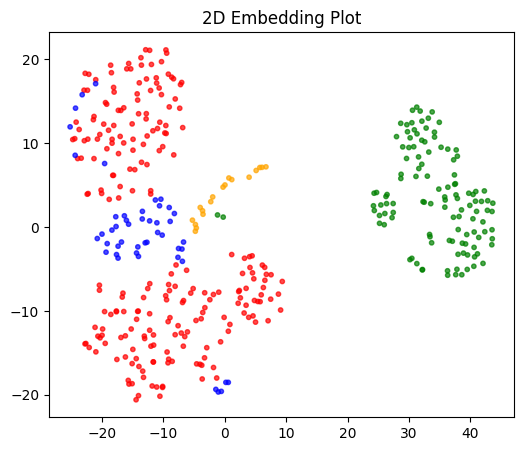

In [20]:
 
tsne = TSNE(n_components=2,random_state=42)
reduced_vectors = tsne.fit_transform(vectors)


import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    reduced_vectors[:, 0],
    reduced_vectors[:, 1],
    c=colors,
    s=10,
    alpha=0.7
)
plt.title("2D Embedding Plot")
plt.show()



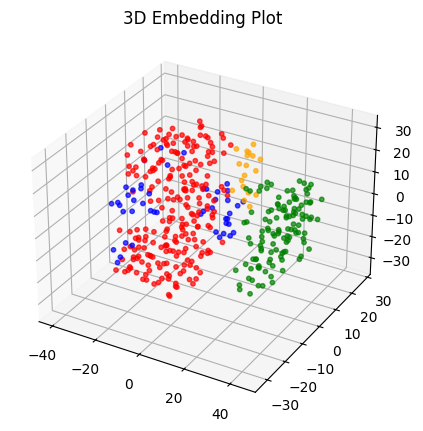

In [21]:
 
tsne = TSNE(n_components=3,random_state=42)
reduced_vectors = tsne.fit_transform(vectors)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    reduced_vectors[:, 0],
    reduced_vectors[:, 1],
    reduced_vectors[:, 2],
    c=colors,
    s=10,
    alpha=0.7
)

ax.set_title("3D Embedding Plot")
plt.show()


In [22]:
import plotly.express as px
fig = px.scatter(
  x=reduced_vectors[:,0],
  y=reduced_vectors[:,1],
  color = doc_types,
  title="2D Embedding Plot"
)

fig.show()

In [23]:
import plotly.express as px
tsne = TSNE(n_components=3,random_state=42)
reduced_vectors = tsne.fit_transform(vectors)
fig = px.scatter_3d(
  x=reduced_vectors[:,0],
  y=reduced_vectors[:,1],
  z=reduced_vectors[:,2],
  color = doc_types,
  title="3D Embedding Plot"
)

fig.show()

In [24]:
import nbformat
print(nbformat.__version__)


5.10.4


In [28]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=3,random_state=42)
embeddings_2d = pca_2d.fit_transform(vectors)

import plotly.express as px


fig = px.scatter_3d(
  x= embeddings_2d[:,0],
  y=embeddings_2d[:,1],
  z=embeddings_2d[:,2],
  color= doc_types,
  title="3D Plotting" 
)

fig.show()

In [34]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2,random_state=42)
embeddings_2d = pca_2d.fit_transform(vectors)

import plotly.express as px


fig_1 = px.scatter(
  x= embeddings_2d[:,0],
  y=embeddings_2d[:,1],
  color= doc_types,
  title="2D Plotting" 
)

fig_1.show()

In [36]:
from sklearn.manifold import TSNE
import plotly.express as ex

tsn_2 =  TSNE(n_components=2,random_state=42)
embeddings_tsne = tsn_2.fit_transform(vectors)

fig = ex.scatter(
  x=embeddings_tsne[:,0],
  y=embeddings_tsne[:,1],
  color= doc_types,
  title="2D plotting TSNE"
)

fig_1.show(),fig.show()


(None, None)